In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from rdkit import Chem
from rdkit.Chem import AllChem

from rdchiral.initialization import rdchiralReactants, rdchiralReaction
from rdchiral.main import rdchiralRun

from temprel.templates.extract import templates_from_reactions, process_for_training, process_for_askcos, unmap

from temprel.templates.validate import validate_template

import glob
import re

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/en

In [2]:
reaction_df = pd.read_json('../data/raw/bkms_reactions.json.gz')
template_df = pd.read_json('../data/processed/bkms-templates.df.json.gz')
templates = pd.read_json('../data/processed/bkms-retro.templates.bkms.json.gz')

def get_unmapped_mol (smiles, stereo = True):
    mol = Chem.MolFromSmiles(smiles)
    
    for at in mol.GetAtoms():
        at.SetAtomMapNum(0)
    
    if stereo:
        return rdchiralReactants(Chem.MolToSmiles(mol))
    else:
        return Chem.MolToSmiles(mol, isomericSmiles=False)


def get_reactant_smiles (reaction_smiles, stereo = True):
    if stereo:
        return sorted(get_unmapped_mol(reaction_smiles.split('>')[0], stereo = stereo).reactant_smiles.split('.'))
    else:
        return sorted(get_unmapped_mol(reaction_smiles.split('>')[0], stereo = stereo).split('.'))

        
def get_product_mol (reaction_smiles, stereo = True):
    if stereo:
        return get_unmapped_mol(reaction_smiles.split('>')[2], stereo = stereo)
    else:
        return Chem.MolFromSmiles(get_unmapped_mol(reaction_smiles.split('>')[2], stereo = stereo))
    
    
df = pd.merge(template_df, reaction_df, on=['reaction_smiles', '_id'], how='outer')
df = df.sort_values(by='count', ascending=False).drop_duplicates(subset=['reaction_smiles'], keep='first')
df = df.loc[:, ['_id', 'ID_y', 'ID_x', 'reaction_smiles', 'reaction_smarts', 'unmapped_template', 'count']]

assert len(template_df[template_df['count']>1]) == len(df[df['count']>1])


#

In [14]:
def get_outcome_smiles(outcome):
    return sorted(outcome.split('.'))

def calc_correctness_promiscuity (df, stereo=True, thresh = 1):
    #initialize
    unique_smarts = df[df['count'] > thresh].drop_duplicates(subset=['unmapped_template'])['reaction_smarts']
    df = df[np.any([df['count']<=thresh, df['count'].isna()], axis = 0)]
    
    if stereo:
    #use rdChiral to run reactions
        df['products'] = df['reaction_smiles'].map(lambda x: get_product_mol(x, stereo=stereo))
        df['reactants'] = df['reaction_smiles'].map(lambda x: get_reactant_smiles(x, stereo=stereo))
        rxns = [rdchiralReaction('(' + smart.replace('>>', ')>>')) for smart in unique_smarts]
    else:
        df['products'] = df['reaction_smiles'].map(lambda x: get_product_mol(x, stereo=stereo))
        df['reactants'] = df['reaction_smiles'].map(lambda x: get_reactant_smiles(x, stereo=stereo))
        rxns = [AllChem.ReactionFromSmarts('(' + smart.replace('>>', ')>>')) for smart in unique_smarts]
    
    correctness = np.zeros((len(df), len(rxns)))
    promiscuity = np.zeros((len(df),len(rxns)))
    print ('Testing {} reactions against {} templates'.format(len(df),len(rxns)))
    
    for (i, (product, reactant)) in enumerate(zip(df['products'], df['reactants'])):
        if i%1000==0:
            print (i)
        for j, rxn in enumerate(rxns):
            if stereo:
                outcomes = rdchiralRun(rxn, product)

                promiscuity[i,j] = len(outcomes)
                for outcome in outcomes:
                    if get_outcome_smiles(outcome) == reactant:
                        correctness[i,j] = True
            else:
                outcomes = rxn.RunReactants([product])
                promiscuity[i,j] = len(outcomes)
                
                for outcome in outcomes:
                    if sorted([Chem.MolToSmiles(mol) for mol in outcome]) == reactant:
                        correctness[i,j] = True
    
    return correctness, promiscuity

In [34]:
for thresh in range(1,6):
    for stereo in (True, False):
        print (thresh)
        prefix = '../data/fold_templates/bkms-thresh_{}_stereo={}_'.format(str(thresh), str(stereo))
        try:
            correctness = np.load('{}correctness.npy'.format(prefix))
            promiscuity = np.load('{}promiscuity.npy'.format(prefix))
        except:
            correctness, promiscuity = calc_correctness_promiscuity(df, thresh=thresh, stereo=stereo)
            np.save('{}correctness.npy'.format(prefix), correctness)
            np.save('{}promiscuity.npy'.format(prefix), promiscuity)

1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
3
0


KeyboardInterrupt: 

In [16]:
correctness, promiscuity = calc_correctness_promiscuity(df, stereo=True, thresh=50, nproc=2)
print (correctness.shape)
print (np.sum(np.sum(promiscuity,axis=1)>0))
print (promiscuity.shape)
print (np.sum(np.sum(correctness, axis=1)>0))

TypeError: calc_correctness_promiscuity() got an unexpected keyword argument 'nproc'

In [17]:
def update_template_df (df, promiscuity, correctness, thresh=1):
    df = df.copy()
#     df = df.drop(columns=['index'])
    unique_smarts = df[df['count'] > thresh].drop_duplicates(subset=['unmapped_template'])['reaction_smarts']
    
    df['products'] = df['reaction_smiles'].map(lambda x: get_product_mol(x, stereo=True))
    df['reactants'] = df['reaction_smiles'].map(lambda x: get_reactant_smiles(x, stereo=True))
    rxns = [rdchiralReaction('(' + smart.replace('>>', ')>>')) for smart in unique_smarts]

    
    reduced_df = df[np.any([df['count']<=thresh, df['count'].isna()], axis = 0)].copy().reset_index()
    
    assert promiscuity.shape == (len(reduced_df), len(rxns))
    assert correctness.shape == (len(reduced_df), len(rxns))
    
    #filter promiscuity matrix to correct reactions
    filt = correctness * promiscuity
    filt[filt==0] = np.inf
    
    #for each correct reaction, pick out the least promiscuous reaction
    best_rxn = np.argmin(filt, axis = 1)
    min_proms = np.min(filt, axis = 1)
    
    assert len(best_rxn) == promiscuity.shape[0]
    
    #re-extract templates for under-precedented reactions
    for i, (rxn_ind, min_prom) in enumerate(zip(best_rxn, min_proms)):
        rxn = rxns[rxn_ind].reaction_smarts
        if min_prom != np.inf: #check for applicability
            reduced_df.loc[i, 'reaction_smarts'] = rxn
            reduced_df.loc[i, 'unmapped_template'] = unmap(rxn)
    
    keep_cols = ['_id', 'reaction_smarts', 'unmapped_template']
    
    new_df = pd.merge(reduced_df[keep_cols], df, on=['_id'], how = 'outer') #combine back with precedented reactions 
    
    
    new_df['unmapped_template'] = new_df['unmapped_template_x'].combine(new_df['unmapped_template_y'],lambda x,y : x if not pd.isna(x) else y)
    new_df['reaction_smarts'] = new_df['reaction_smarts_x'].combine(new_df['reaction_smarts_y'], lambda x,y : x if not pd.isna(x) else y)
                                                                            
    
    
    new_df = new_df.dropna(subset = ['reaction_smarts', 'products', 'reactants'])
    
    
    
    new_df['products'] = new_df['products'].apply(lambda x: x.reactant_smiles)
    new_df['reactants'] = new_df['reactants'].apply(lambda x: '.'.join(x))
    print ("Before val:", len(new_df))
    valid = [validate_template(template)
        for template in new_df.to_dict(orient="records")
            ] #validate
    
    new_df = new_df[valid]
    print ("After val:", len(new_df))
    
    #redo template counts
    unique_templates = pd.DataFrame(new_df['unmapped_template'].unique(), columns=['unmapped_template']).reset_index()
    new_df = new_df.merge(unique_templates, on='unmapped_template')
    new_df = new_df.drop_duplicates(subset=['products', 'index'])
    new_df['count'] = new_df.groupby('index')['index'].transform('count') 
    new_df = new_df.dropna(subset=['unmapped_template'])
    return new_df
    

In [21]:
from rdkit.Chem import AllChem as Chem
from rdchiral.initialization import rdchiralReactants, rdchiralReaction
from rdchiral.main import rdchiralRun

def rdchiral_run_reactions (reaction_smarts:str, reactant_smiles:str):
    """
    Apply a list of reaction SMARTS to a reactant SMILES using
    rdchiral
    """
    reactant = rdchiralReactants(reactant_smiles)
    reactions = [rdchiralReaction(rxn) for rxn in reaction_smarts]
    products = [rdchiralRun(rxn, reactant) for rxn in reactions]
    return products

def rdkit_run_reactions (reaction_smarts:str, reactant_smiles:str):
    """
    Apply a list of reaction SMARTS to a reactant SMILES using
    rdkit
    """
    reactant = Chem.MolFromSmiles(reactant_smiles)
    reactions = [Chem.ReactionFromSmarts(rxn) for rxn in reaction_smarts]
    products = [rxn.RunReactants([reactant]) for rxn in reactions]
    return products


## Compare coverage

In [22]:
# true/false correspond to stereochemistry being taken into account or not
# keys in each dict are the threshold for the count of precedents templates must have
# values are the total number of reactants recovered

coverage_results = {'true':{}, 'false':{}}
correctness_files = glob.glob('../data/fold_templates/16Jun*correctness.npy')
promiscuity_files = glob.glob('../data/fold_templates/16Jun*promiscuity.npy')

for file in correctness_files:
    thresh = int(re.findall('_[0-9]_', file)[0].replace('_',''))
    stereo = re.findall('True|False', file)[0].lower()
    coverage_results[stereo][thresh] = np.sum(np.sum(np.load(file), axis=1)>0)


In [23]:
coverage_results

{'true': {5: 1831, 1: 1990, 4: 1902, 2: 1980, 3: 1945},
 'false': {5: 2368, 3: 2486, 1: 2553, 2: 2576, 4: 2396}}

In [24]:
db_counts = {thresh : len(df[df['count']>thresh].dropna(subset=['count'])) for thresh in range(6)}

In [25]:
stereo = [db_counts[0]]
no_stereo = [db_counts[0]]

for i in range(1,6):
    try:
        stereo.append(db_counts[i] + coverage_results['true'][i])
    except KeyError as e:
        print(e)
    try:
        no_stereo.append(db_counts[i] + coverage_results['false'][i])
    except KeyError as e:
        print(e)

In [26]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

figure_dir = '/Users/Itai/Box Sync/Grad/Manuscripts/Chemonzymatic_planner/matplotlib_figures/'
plt.rcParams['figure.figsize'] = (2.5,1.7)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 7
# plt.rcParams['legend.markerscale'] = 0

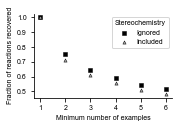

In [12]:
plt.figure()
plt.scatter(np.arange(len(np.array(stereo)))+1, np.array(no_stereo)/db_counts[0], marker='s',  c='black', s=10, edgecolor='black', linewidth=0.5, label = 'Ignored')
plt.scatter(np.arange(len(np.array(stereo)))+1, np.array(stereo)/db_counts[0], marker='^', c='darkgray', s=10, edgecolor='black', linewidth=0.5, label='Included')

plt.xticks(range(1, 7))
plt.xlabel('Minimum number of examples')
plt.ylabel('Fraction of reactions recovered')
plt.legend(title='Stereochemistry')

plt.tight_layout()
plt.savefig(figure_dir+'comparing_coverage.pdf', dpi=300)
plt.show()


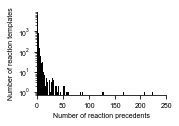

In [53]:
plt.figure()
ax = plt.hist(templates['count'], log = True, bins = 250, range = (0, 250), color='black')
plt.xlim(0, templates['count'].max()+15)

plt.xlabel('Number of reaction precedents')
plt.ylabel('Number of reaction templates')


plt.tight_layout()
plt.savefig(figure_dir+'number_of_precedents.pdf', dpi=300)
plt.show()

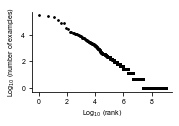

In [14]:
plt.figure()

counts = templates['count'].values

counts = np.flip(np.sort(counts))
ranks = np.flip(np.argsort(counts)+1)

plt.scatter(np.log(ranks), np.log(counts), color='black', s=3, )
# plt.hist(templates['count'], log = True, bins = 250, range = (0, 250), color='black')
# plt.xlim(0, templates['count'].max()+15)

plt.ylabel(r'Log$_{10}$ (number of examples)')
plt.xlabel(r'Log$_{10}$ (rank)')

plt.tight_layout()
plt.savefig(figure_dir+'number_of_precedents_zipfs.pdf', dpi=300)
plt.show()

In [107]:
templates[templates['count']==templates['count'].max()]

,index,reaction_smarts,necessary_reagent,intra_only,dimer_only,count,template_set,references,attributes,_id
468,468,[C:1]-[O;H0;D2;+0:2]-[P;H0;D4;+0](=[O;H0;D1;+0...,[O]~[P](~[O])~[O],True,False,235,bkms,"[2787, 2788, 2789, 2790, 2791, 2792, 2793, 279...","{'ring_delta': 0.0, 'chiral_delta': 0}",d6ed9368f180ea95b69d8a0543ec8411


In [108]:
len(templates)

7984

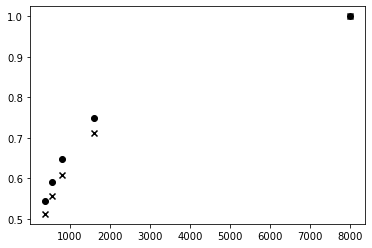

In [33]:
template_counts = [7984, 1597, 804, 548, 392]

plt.scatter(template_counts, np.array(stereo)/db_counts[0], marker='x', color='black')
plt.scatter(template_counts, np.array(no_stereo)/db_counts[0], color='black')
plt.show()

In [126]:
unique_smarts = df[df['count'] > 1].drop_duplicates(subset=['unmapped_template'])['reaction_smarts']
rxns = [rdchiralReaction('(' + smart.replace('>>', ')>>')) for smart in unique_smarts]

In [25]:
len(unique_smarts)

1597

In [114]:
correctness_stereo = np.load('../data/fold_templates/14Jun2021-bkms-thresh_1_stereo=False_correctness.npy')
promiscuity_stereo = np.load('../data/fold_templates/14Jun2021-bkms-thresh_1_stereo=False_promiscuity.npy')

In [192]:
new_df, valid = update_template_df (df, promiscuity_stereo, correctness_stereo, thresh=1)

Before val: 37425


In [204]:
smarts, prods, reactants = new_df[np.array(valid) != True].loc[:, ['reaction_smarts', 'products', 'reactants']].values[10]

In [223]:
unique_smarts

1        [C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...
2        [#7:4]-[C:5](=[O;D1;H0:6])-[C:7]-[NH;D2;+0:8]-...
4        [C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:4...
5        [O;D1;H0:1]=[C:2]1-[#8:3]-[C:4]-[C;H0;D3;+0:5]...
6        [O;H0;D1;+0:1]=[CH;D2;+0:2]-[c:3]>>[OH;D1;+0:1...
                               ...                        
32767    [#8:2]-[C@H;D3;+0:1](-[C:3])-[O;H0;D2;+0:4]-[c...
32848    [C:2]-[SH;D1;+0:1]>>O-S(=O)(=O)-C-C-S-[S;H0;D2...
32859    [C:2]-[NH2;D1;+0:1]>>O-c1:n:c(-O):n:c(-[NH;D2;...
32873    [C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[O;H1;D1;+0...
32909      [C:2]-[NH2;D1;+0:1]>>N-C-C-C-[NH;D2;+0:1]-[C:2]
Name: reaction_smarts, Length: 1597, dtype: object

<AxesSubplot:>

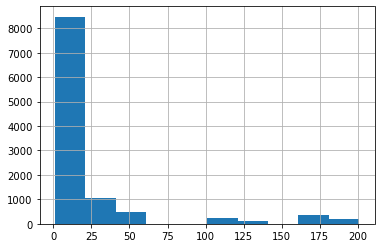

In [164]:
new_df['count'].hist()

In [165]:
df

,ID,reaction_smiles,reaction_smarts,unmapped_template,count,products,reactants
0,1,[O:1]=[C:2]([S:3][CH2:4][CH2:5][NH:6][C:7](=[O...,[CH3;D1;+0:1]/[CH;D2;+0:2]=[CH;D2;+0:3]/[C:4]=...,[CH3;D1;+0]/[CH;D2;+0]=[CH;D2;+0]/[C]=[O;D1;H0...,1.0,<rdchiral.initialization.rdchiralReactants obj...,[C=CCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(...
1,2,O[C:2](=[O:1])[C@H:3]([OH:4])[C:5]([CH3:6])([C...,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,[C]-[NH;D2;+0]-[C;H0;D3;+0](-[C])=[O;D1;H0]>>O...,41.0,<rdchiral.initialization.rdchiralReactants obj...,"[CC(C)(CO)[C@@H](O)C(=O)O, NCCC(=O)O]"
2,3,O[C:2](=[O:1])[C@@H:3]([NH:4][C:5](=[O:6])[CH2...,[#7:4]-[C:5](=[O;D1;H0:6])-[C:7]-[NH;D2;+0:8]-...,[#7]-[C](=[O;D1;H0])-[C]-[NH;D2;+0]-[C;H0;D3;+...,9.0,<rdchiral.initialization.rdchiralReactants obj...,[CC(=O)N[C@@H]1[C@@H](O[C@H](C)C(=O)N[C@@H](C)...
3,4,O[C:2](=[O:1])[C@@H:3]([NH:4][C:5](=[O:6])[CH2...,NaN,NaN,NaN,<rdchiral.initialization.rdchiralReactants obj...,[CC(=O)N[C@@H]1[C@@H](O[C@H](C)C(=O)N[C@@H](C)...
4,5,O[C:13](=[O:12])[CH2:14][CH2:15][NH2:16].[O:1]...,[C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:4...,[C]-[C;H0;D3;+0](=[O;D1;H0])-[NH;D2;+0]-[C]-[C...,65.0,<rdchiral.initialization.rdchiralReactants obj...,"[NCCC(=O)O, N[C@@H](Cc1c[nH]cn1)C(=O)O]"
...,...,...,...,...,...,...,...
32947,6757,CC1=C(/C=[CH:17]/[C:16](=[CH:15]/[CH:14]=[CH:1...,NaN,NaN,NaN,<rdchiral.initialization.rdchiralReactants obj...,[CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C...
32948,6758,CC1=C(/C=[CH:17]/[C:16](=[CH:15]/[CH:14]=[CH:1...,NaN,NaN,NaN,<rdchiral.initialization.rdchiralReactants obj...,[CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C...
32949,7563,CC1(C)C[C@H](O)C[C:4]([CH3:42])=[C:5]1/[CH:6]=...,NaN,NaN,NaN,<rdchiral.initialization.rdchiralReactants obj...,[CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C...
32950,7564,CC1(C)C[C@H](O)C[C:4]([CH3:42])=[C:5]1/[CH:6]=...,NaN,NaN,NaN,<rdchiral.initialization.rdchiralReactants obj...,[CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C...


In [46]:
updated_df_dicts = {}

for i in range(1,6):
    correctness = np.load('../data/fold_templates/16Jun2021-bkms-thresh_{}_stereo=False_correctness.npy'.format(i))
    promiscuity = np.load('../data/fold_templates/16Jun2021-bkms-thresh_{}_stereo=False_promiscuity.npy'.format(i))
    updated_df_dicts[i] = update_template_df (df, promiscuity, correctness, thresh=i)
    

Before val: 18229
After val: 13590
Before val: 18480
After val: 13756
Before val: 18534
After val: 13862
Before val: 18608
After val: 13947
Before val: 18677
After val: 13982


In [65]:
template_df[template_df['count']>1]

,ID,EC_Number,Recommended_Name,Reaction,Reaction_ID_BRENDA,Reaction_ID_KEGG,Reaction_ID_MetaCyc,Reaction_ID_SABIO_RK,BRENDA_Pathway_Name,KEGG_Pathway_ID,...,spectators,products,dimer_only,intra_only,necessary_reagent,reaction_id,reaction_smarts,unmapped_template,index,count
1,2,6.3.2.1,pantoate-beta-alanine ligase (AMP-forming),ATP + (R)-pantoate + beta-alanine = AMP + diph...,BR101,R02473,PANTOATE-BETA-ALANINE-LIG-RXN,2406,pantothenate biosynthesis,rn00410; rn00770; rn01110,...,,[O:1]=[C:2]([C@H:3]([OH:4])[C:5]([CH3:6])([CH3...,False,False,,1,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,[C]-[NH;D2;+0]-[C;H0;D3;+0](-[C])=[O;D1;H0]>>O...,1,41
2,115,6.3.2.20,indoleacetate-lysine synthetase,ATP + (indol-3-yl)acetate + L-lysine = ADP + p...,BR113,R03095,INDOLEACETATE--LYSINE-LIGASE-RXN,None,None,None,...,,[O:1]=[C:2]([CH2:3][c:4]1[cH:5][nH:6][c:7]2[cH...,False,False,,78,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,[C]-[NH;D2;+0]-[C;H0;D3;+0](-[C])=[O;D1;H0]>>O...,1,41
3,13326,6.3.1.12,D-aspartate ligase,ATP + D-aspartate + [beta-GlcNAc-(1->4)-Mur2Ac...,BR48776,None,None,None,None,None,...,,[O:1]=[C:2]([OH:3])[C@H:4]([NH:5][C:6](=[O:7])...,False,False,,2083,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,[C]-[NH;D2;+0]-[C;H0;D3;+0](-[C])=[O;D1;H0]>>O...,1,41
4,16184,None,None,Vanillylamine + 8-Methyl-6-nonenoic acid <=> C...,None,R09091,RXN-8927,None,None,rn00360; rn01110,...,,[O:1]=[C:2]([CH2:3][CH2:4][CH2:5][CH2:6]/[CH:7...,False,False,,3776,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,[C]-[NH;D2;+0]-[C;H0;D3;+0](-[C])=[O;D1;H0]>>O...,1,41
5,21777,2.3.2.2,gamma-glutamyltransferase,3-Aminopropiononitrile + L-Glutamate <=> gamma...,None,R03971,None,None,None,rn00460,...,,[O:1]=[C:2]([CH2:3][CH2:4][C@H:5]([NH2:6])[C:7...,False,False,,4514,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,[C]-[NH;D2;+0]-[C;H0;D3;+0](-[C])=[O;D1;H0]>>O...,1,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24102,81546,3.5.1.97,acyl-homoserine-lactone acylase,N-undecanoyl-(S)-homoserine lactone + H2O = (S...,BS380673,None,None,None,None,None,...,,O[C:2](=[O:1])[CH2:10][CH2:11][CH2:12][CH2:13]...,False,True,[O],28611,[C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[O;H1;D1;+0...,[C]-[C;H0;D3;+0](=[O;D1;H0])-[O;H1;D1;+0]>>O=C...,7962,2
24104,1074,4.3.3.4,deacetylipecoside synthase,deacetylipecoside + H2O = dopamine + secologanin,"BR26151,BS165634",R05749,4.3.3.4-RXN,None,None,rn00950,...,,O=[CH:26][CH2:25][C@@H:24]1[C:5]([C:2](=[O:1])...,False,True,[O],28613,[C:2]-[CH;D2;+0:1]=[O;H0;D1;+0]>>O-c1:c:c2:c(:...,[C]-[CH;D2;+0]=[O;H0;D1;+0]>>O-c1:c:c2:c(:c:c:...,7964,2
24105,15738,None,None,Protoemetine + Dopamine <=> 7'-O-Dmethylcephae...,None,None,RXN-13794,None,None,None,...,,O=[CH:1][CH2:2][CH:3]1[CH2:4][C@H:5]2[c:6]3[cH...,False,True,[O],28615,[C:2]-[CH;D2;+0:1]=[O;H0;D1;+0]>>O-c1:c:c2:c(:...,[C]-[CH;D2;+0]=[O;H0;D1;+0]>>O-c1:c:c2:c(:c:c:...,7964,2
24115,21112,1.5.3.16,spermine oxidase,norspermine + oxygen + H2O = norspermidine + 3...,None,None,RXN-10464,11362,None,None,...,,[NH2:1][CH2:2][CH2:3][CH2:4][NH:5][CH2:6][CH2:...,False,True,,28643,[C:2]-[NH2;D1;+0:1]>>N-C-C-C-[NH;D2;+0:1]-[C:2],[C]-[NH2;D1;+0]>>N-C-C-C-[NH;D2;+0]-[C],7973,2


In [64]:
{k:len(v[v['count']>k]) for k,v in updated_df_dicts.items()}

{1: 7896, 2: 6756, 3: 6133, 4: 5622, 5: 5305}

In [61]:
updated_df_dicts[4].drop_duplicates(subset=['reaction_smiles'])

,_id,reaction_smarts_x,unmapped_template_x,ID_y,ID_x,reaction_smiles,reaction_smarts_y,unmapped_template_y,count,products,reactants,unmapped_template,reaction_smarts,index
0,16811,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,NaN,10050.0,[OH:1][N:2]=[C:3]([S:4][C@@H:5]1[O:6][C@H:7]([...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,4,O=S(=O)(O)ON=C(Cc1ccc(O)cc1)S[C@@H]1O[C@H](CO)...,OC[C@H]1O[C@@H](SC(Cc2ccc(O)cc2)=NO)[C@H](O)[C...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,0
2,28311,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,NaN,15128.0,[OH:32][N:33]=[C:34]([S:35][C@@H:36]1[O:37][C@...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,4,CSCCCCCCCCC(=NOS(=O)(=O)O)S[C@@H]1O[C@H](CO)[C...,CSCCCCCCCCC(=NO)S[C@@H]1O[C@H](CO)[C@@H](O)[C@...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,0
3,28310,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,NaN,15127.0,[OH:32][N:33]=[C:34]([S:35][C@@H:36]1[O:37][C@...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,4,CSCCCCCCCC(=NOS(=O)(=O)O)S[C@@H]1O[C@H](CO)[C@...,CSCCCCCCCC(=NO)S[C@@H]1O[C@H](CO)[C@@H](O)[C@H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,0
5,28319,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,NaN,11402.0,[OH:32][N:33]=[C:34]([S:35][C@@H:36]1[O:37][C@...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,4,O=S(=O)(O)ON=C(Cc1c[nH]c2ccccc12)S[C@@H]1O[C@H...,OC[C@H]1O[C@@H](SC(Cc2c[nH]c3ccccc23)=NO)[C@H]...,[C]=[#7]-[O;H0;D2;+0]-[S;H0;D4;+0](=[O;H0;D1;+...,[C:1]=[#7:2]-[O;H0;D2;+0:3]-[S;H0;D4;+0](=[O;H...,0
6,27979,[O;D1;H0:1]=[C:2]-[OH;D1;+0:3]>>[O;D1;H0:1]=[C...,[O;D1;H0]=[C]-[OH;D1;+0]>>[O;D1;H0]=[C]-[O;H0;...,NaN,26283.0,c1ccc(C[O:3][C:2](=[O:1])[c:11]2[cH:12][cH:13]...,[O;D1;H0:1]=[C:2]-[OH;D1;+0:3]>>[O;D1;H0:1]=[C...,[O;D1;H0]=[C]-[OH;D1;+0]>>[O;D1;H0]=[C]-[O;H0;...,3,O=C(O)c1ccccc1,O=C(OCc1ccccc1)c1ccccc1,[O;D1;H0]=[C]-[OH;D1;+0]>>[O;D1;H0]=[C]-[O;H0;...,[O;D1;H0:1]=[C:2]-[OH;D1;+0:3]>>[O;D1;H0:1]=[C...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13942,12421,NaN,NaN,61089.0,61089.0,[O:1]=[C:2]1[CH:3]=[C:4]([CH3:5])[CH2:6][CH:7]...,[C:1]-[CH;D3;+0:2](-[C;D1;H3:3])-[CH2;D2;+0:4]...,[C]-[CH;D3;+0](-[C;D1;H3])-[CH2;D2;+0]-[C]=[O;...,4,CC1CC(=O)CC(C)C1,CC1=CC(=O)CC(C)C1,[C]-[CH;D3;+0](-[C;D1;H3])-[CH2;D2;+0]-[C]=[O;...,[C:1]-[CH;D3;+0:2](-[C;D1;H3:3])-[CH2;D2;+0:4]...,6243
13943,12594,NaN,NaN,62542.0,62542.0,[O:1]=[C:2]1[CH:3]=[C:4]([CH3:5])[CH2:6][C:7](...,[C:1]-[CH;D3;+0:2](-[C;D1;H3:3])-[CH2;D2;+0:4]...,[C]-[CH;D3;+0](-[C;D1;H3])-[CH2;D2;+0]-[C]=[O;...,4,CC1CC(=O)CC(C)(C)C1,CC1=CC(=O)CC(C)(C)C1,[C]-[CH;D3;+0](-[C;D1;H3])-[CH2;D2;+0]-[C]=[O;...,[C:1]-[CH;D3;+0:2](-[C;D1;H3:3])-[CH2;D2;+0:4]...,6243
13944,12675,NaN,NaN,63269.0,63269.0,[O:1]=[C:2]1[CH:3]=[C:4]([CH3:5])[CH2:6][CH2:7...,[C:1]-[CH;D3;+0:2](-[C;D1;H3:3])-[CH2;D2;+0:4]...,[C]-[CH;D3;+0](-[C;D1;H3])-[CH2;D2;+0]-[C]=[O;...,4,CC1CCC(C(C)C)C(=O)C1,CC1=CC(=O)C(C(C)C)CC1,[C]-[CH;D3;+0](-[C;D1;H3])-[CH2;D2;+0]-[C]=[O;...,[C:1]-[CH;D3;+0:2](-[C;D1;H3:3])-[CH2;D2;+0:4]...,6243
13945,18429,NaN,NaN,NaN,16295.0,[O:1]=[C:2]([S:3][CH2:4][CH2:5][NH:6][C:7](=[O...,[C:1]-[CH;D3;+0:2](-[O;H1;D1;+0])-[CH2;D2;+0:3...,[C]-[CH;D3;+0](-[O;H1;D1;+0])-[CH2;D2;+0]-[C]=...,2,CCCCCCCCCCCCCCCC(O)CC(=O)SCCNC(=O)CCNC(=O)[C@H...,CCCCCCCCCCCCCCC/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@H...,[C]-[CH;D3;+0](-[O;H1;D1;+0])-[CH2;D2;+0]-[C]=...,[C:1]-[CH;D3;+0:2](-[O;H1;D1;+0])-[CH2;D2;+0:3...,6244


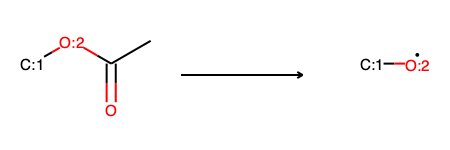

In [53]:
AllChem.ReactionFromSmarts('([C:1]-[O;H0;D2;+0:2]-[C;H0;D3;+0](-[C;H3;D1;+0])=[O;H0;D1;+0])>>[C:1]-[OH;D1;+0:2]')

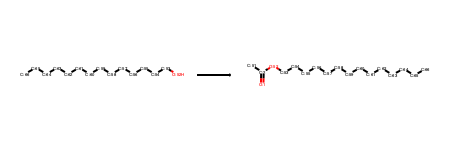

In [55]:
AllChem.ReactionFromSmarts('[OH:52][CH2:53][CH2:54][CH2:55][CH2:56][CH2:57][CH2:58][CH2:59][CH2:60][CH2:61][CH2:62][CH2:63][CH2:64][CH2:65][CH3:66]>>[O:1]=[C:2]([CH3:51])[O:52][CH2:53][CH2:54][CH2:55][CH2:56][CH2:57][CH2:58][CH2:59][CH2:60][CH2:61][CH2:62][CH2:63][CH2:64][CH2:65][CH3:66]', useSmiles=True)